# Possible Advantage in Memory with the QEMC Algorithm - Notebook 2

**Ohad Lev**

**September 2023**

In this notebook, we dive into a few points as our effort to look for a possible advantage in memory consumption by utilizing the QEMC [[1]](#References) algorithm to approximate maximum cuts of large graphs continues. Specifically, in this report we study the following aspects and questions:

1. The problem we look into is not exactly MaxCut (which is NP-Hard), but rather a problem called $(k, n - k)$-MaxCut [[2]](#References) (in our notation - $(B, N - B)$-MaxCut), which is phrased as follows: given a graph $G = (V, E)$ with $N = |V|$ nodes and $|E|$ edges, divide its nodes into two complementary subsets of cardinality $B$ and $N - B$, such that the number of connecting edges between nodes of different subsets is maximized. **What is the computational complexity of this problem variant?**

2. **What values of $B$ are of interest to our cause of achieving an advantage in memory using the QEMC algorithm?** (we call the $B$ nodes "blue" nodes, while the rest $N - B$ nodes are "red" nodes). To better demonstrate that, let us have a look at $2$ extreme examples - in general, to solve MaxCut exactly one has to check all $2^N$ possibilities of associating each node with one of $2$ colors. In the easiest case of $B = 1$, one has to check ${N\choose{B}} = {{N}\choose{1}} = N$ possibilities overall, which is efficient, thus no need for QEMC or any other approximation algorithm. Somewhere in between, there may be a value of $B$ that provides a possibility for memory advantage.

3. Our idea for memory advantage using the QEMC algorithm is based upon an assumption that graphs of interest can be constructed by exploiting some on-line [[3]](#References) technique, which makes the need for saving the graph instance in memory redundant. However, **we need to find out whether classical approximation algorithms, and especially the GW algorithm [[4]](#References), can work with on-line constructed graphs as well?**

4. **It will be interesting to verify our thoughts via initial simulations of this QEMC-variant algorithm we develop, while testing several graph instances and different $B$ values**.

## $\S\ \text{I} $ - Complexity of the $(k, n - k)$-MaxCut Problem

The $(k, n - k)$-MaxCut problem is treated in [[2]](#References), while introducing a (complex) algorithm that solves the problem exactly in $O^*(2^p)$ time, where $p$ is the size of the cut (the $O^*$ notation indicates an omission of sub-exponential terms). To my knowledge, this is the most efficient (exact) solver for the $(k, n - k)$-MaxCut introduced so far. Since for $p < \frac{|E|}{2}$ efficient algorithms (e.g. simple randomized partition) are known [[2][5]](#References), <span style="color: green; font-weight: bold;">it is evident that for any interesting value of $p$, the $(k, n - k)$-MaxCut problem is exponentially hard, with complexity of $O^* \big( 2^{|E|} \big)$</span>.

Another interesting question to look into regarding this problem is which classical approximation algorithms exist that treat this problem, how good and efficient are they, and how they work. We leave this issue for future analysis.

## $\S\ \text{II}$ - Interesting $B$ Values

As mentioned, our idea of advantage in memory using QEMC is based upon an efficient on-line construction of the graph, which makes the saving of the graph structure on memory redundant. The objective function of the QEMC algorithm "consumes" probability values from a probability distribution, which in turn is constructed from multiple measurement outcomes of the QEMC's Ansatz. Originially, this probability distribution corresponds to the quantum statevector of the Ansatz, hence it is of dimension $N$. Thus, if we save the entire probability distribution in memory no advantage can be achieved. However, if we decide to execute and measure the Ansatz exactly $B^2$ times, the dimension of the resulting probability distribution is $O(B^2)$.

Naturally, we now address the following question: which values of $B$ can provide an asymptotic advantage in memory? Clearly, $B = \sqrt{N}$ is an upper bound, since the dimension of the probability distribution we save in memory will be $O(B^2) = O(N)$. It seems that $B = N^{\frac{1}{s}}$ potentially can provide an increasing polynomial advantage in memory as $s$ grows, and $B = \log{N}$ should provide an exponential advantage.

However, as we make $B$ smaller we get closer to the easy case of $B = 1$ explained above, therefore we must analyze it carefully. For now, we ignore the performance of the QEMC algorithm with respect to a certain $B$ value, as we address and test this issue in [$\S\ \text{IV}$](#$\S\-\text{IV}$---Numerical-Tests).

Since we are looking for a partition of the nodes into $2$ complementary subsets of cardinality $B$ and $N - B$, the question detailed above boils down to the scaling of the number of possible combinations to choose $B$ blue nodes out of $N$ nodes total, without repetitions, which is described by the following well-known equation:

$$ {N \choose B} = \frac{N!}{B!(N - B)!} \tag{1} $$

In [[6]](#References), the following upper and lower bounds on $\binom{N}{B}$ are derived:

$$ \bigg( \frac{N}{B} \bigg)^B \leq \binom{N}{B} \leq \bigg( \frac{eN}{B} \bigg)^B \tag{2}$$

It looks like both the upper and lower bounds grow exponentially with $B$. In addition, note that the function $\binom{N}{B}$ with constant $N$ is symmetric. Let us now plot $\binom{N}{B}$ with the bounds (which we tight further by exploiting the symmetry):

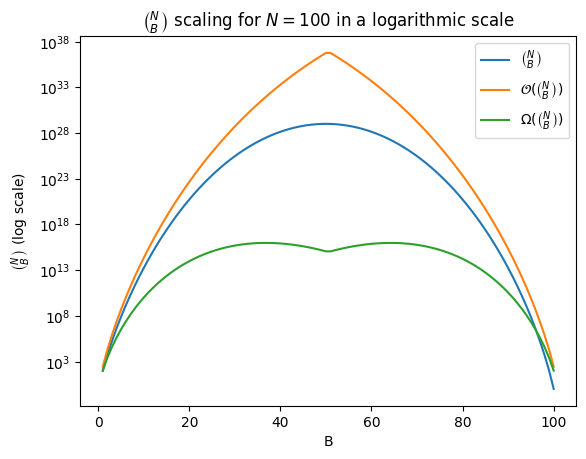

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

N = 100
half = int(N / 2)
B = np.arange(1, N + 1)
N_choose_B = binom(N, B)

upper_bound = ((np.e * N) / B[:half])**B[:half]
upper_bound = np.concatenate((upper_bound, upper_bound[::-1]), axis=0)

lower_bound = (N / B[:half])**B[:half]
lower_bound = np.concatenate((lower_bound, lower_bound[::-1]), axis=0)

plt.plot(B, N_choose_B, label="$\\binom{N}{B}$")
plt.plot(B, upper_bound, label="$\\mathcal{O}(\\binom{N}{B})$")
plt.plot(B, lower_bound, label="$\\Omega(\\binom{N}{B})$")
plt.yscale("log")

plt.xlabel("B")
plt.ylabel("$ \\binom{N}{B} $ (log scale)")
plt.title("$\\binom{N}{B}$ scaling for $N = 100$ in a logarithmic scale")
plt.legend()

plt.show()

To conclude, the lower bound of $\binom{N}{B}$ is still exponential in $B$, therefore <span style="color: green; font-weight: bold;">any sub-exponential restriction on $B$ as a function of $N$ is a candidate for possible memory advantage but still hard computationally</span>.

## $\S\ \text{III} $ - Constructing Graphs On-Line and Classical Algorithms Applicability

It's not hard to think of a function that gets as input an index of a node and returns its adjacent nodes. Assuming such a function exists and is useful, it can be naturally integrated with the objective function defined in the QEMC paper [[1]](#References):

$$ C(G) = \sum^{}_{\{i, j\} \in E} \bigg( p_i + p_j - \frac{1}{B} \bigg)^2 + \bigg( |p_i - p_j| - \frac{1}{B} \bigg)^2 \tag{3} $$

Where $p_k$ is the probability associated with the $k$th node, taken from a probability distribution reconstructed by multiple measurements of the QEMC's Ansatz.

As easily seen above, the objective function iterates over the edges of the graph sequentially, hence it is agnostic to whether the entire graph structure is within reach or not.

The GW MaxCut approximation algorithm [[4]](#References) works roughly as follows:

1. The MaxCut problem is formulated as a simple quadratic integer program (in this report we consider the case of unweighted graphs only):

$$
    \text{maximize}\ f(y) = \frac{1}{2} \sum^{}_{\{i, j\} \in E} 1 - y_i y_j \\
    \text{subject to:}\ y_k \in \{-1, +1 \} \ \ \ \ \ \ \ \ \forall k \in V
    \tag{4}
$$

Where $y$ is a binary vector, $y_k = 1$ indicates "blue" nodes, and $y_k = -1$ indicates "red" nodes. $f(y)$ is the cut of the partition defined by $y$.

2. The binary variables $y_i, y_j \in \{+1, -1 \}$ are relaxed into unit vectors $v_i, v_j \in \mathbb{R}^N$ and the above formulation is mapped into:

$$
    \text{maximize}\ g(v) = \frac{1}{2} \sum^{}_{\{ i, j \} \in E} 1 - v_i \cdot v_j \\
    \text{subject to:}\ v_k \in S_N \ \ \ \ \ \ \ \ \forall k \in V
    \tag{5}
$$

Where $v$ is a vector that contains $N$ vectors $v_k \in \mathbb{R}^N$, and $S_N$ is the unit $N$-hypersphere.

3. Then, a final formulation into an SDP form is as follows:

$$
    \text{maximize}\ \frac{1}{2} \sum^{}_{\{ i, j \} \in E} 1 - y_{ij} \\
    \text{subject to}\ Y \succeq 0,\ y_{kk} = 1 \ \ \ \ \ \ \ \ \forall k \in V
    \tag{6}
$$

Where $Y = B^T B$, and $B$ is a matrix whose columns are the $v_k$ vectors:

$$ B = \begin{bmatrix} v_1 & ... & v_N \end{bmatrix} \tag{7} $$

Therefore, the GW algorithm requires $\Omega(N^2)$ memory, either in its offline version, and also probably in its (possible) online variants. So to conclude, in general, <span style="color: green; font-weight: bold;">the GW algorithm can't provide any possible advantage in memory</span>.

However, there are still $2$ questions that should be further checked:

1. If we relax the binary variables into vectors of dimension significantly smaller than $N$ - how does it affect the applicability and performance of the GW algorithm?
2. Other classical solvers and heuristics should be checked.

## $\S\ \text{IV}$ - Numerical Tests

In this section, we perform initial numerical tests (using noiseless simulators) for our heuristic *Online (B, N-B)-MaxCut* solver, for $2$ instances - a small graph with $N = 8$ nodes and a medium-size graph with $N = 64$ nodes. In both instances, we set $B = N^{\frac{1}{3}}$ (so the number of probability values we save on memory is $N^{\frac{2}{3}}$). The algorithm computes everything online, but we do generate and present the entire graphs for the sake of the completeness of the analysis. We benchmark the results obtained by the *Online (B, N-B)-MaxCut* algorithm with those obtained by brute force (for $N = 8$ nodes) and by a simple randomized algorithm.

### $8$ Nodes Instance

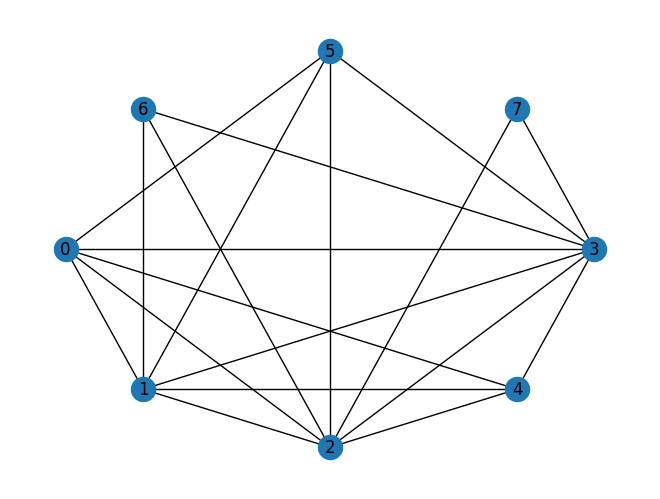

In [2]:
import networkx as nx

from online_graph_gen import get_adj_nodes, gen_whole_graph

NUM_NODES_1 = 8 # N
NUM_BLUE_NODES_1 = 2 # B = N^(1/3)

graph_1 = nx.Graph(gen_whole_graph(NUM_NODES_1))
pos_1 = nx.shell_layout(graph_1)

nx.draw(graph_1, with_labels=True, pos=pos_1)

In [3]:
from classical_solvers import get_maxcut_brute_force, get_random_partition, compute_cut

print("BRUTE FORCE:")
print(
    get_maxcut_brute_force(graph_1, blue_nodes=NUM_BLUE_NODES_1)
)

BRUTE FORCE:
('00110000', 12)


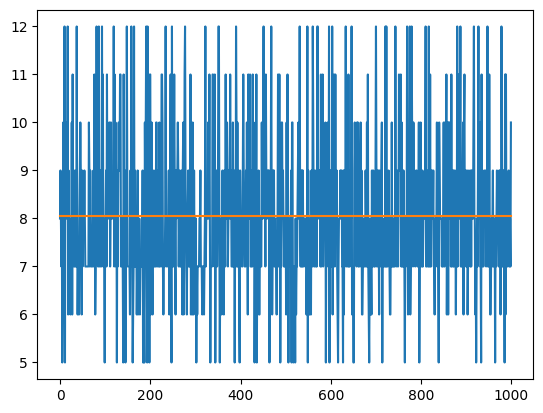

Average random cut for B=2: 8.052


In [4]:
import matplotlib.pyplot as plt


random_epochs = 1_000

x = np.arange(random_epochs)
y = np.zeros(random_epochs)

for i in range(random_epochs):
    rand_bitstring = get_random_partition(NUM_NODES_1, NUM_BLUE_NODES_1)
    y[i] = compute_cut(graph_1, rand_bitstring)
    
plt.plot(x, y)
plt.plot(x, [y.mean() for _ in range(random_epochs)])

plt.show()
print(f"Average random cut for B={NUM_BLUE_NODES_1}: {y.mean()}")

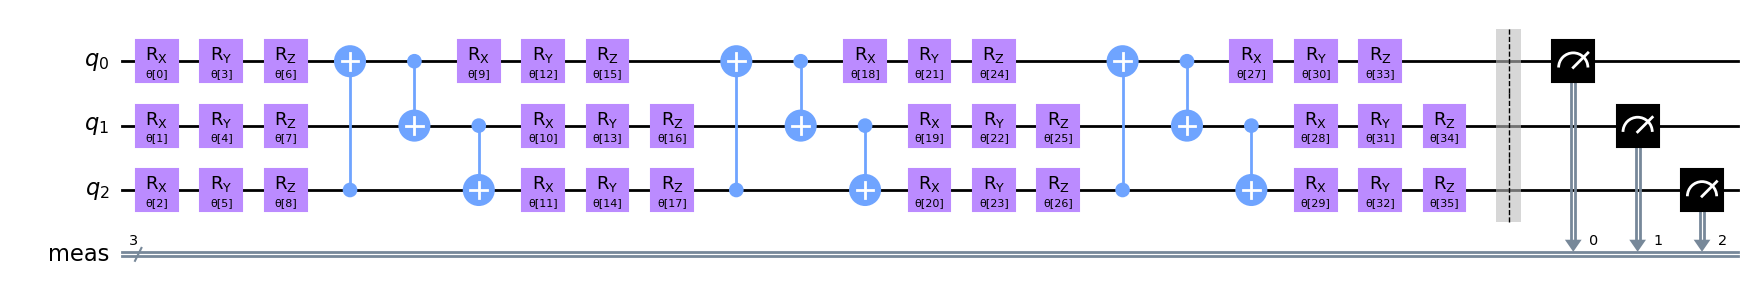

In [5]:
from qiskit.circuit.library import EfficientSU2

NUM_QUBITS_1 = int(np.log2(NUM_NODES_1))

ansatz_1 = EfficientSU2(
    num_qubits=NUM_QUBITS_1,
    reps=3,
    su2_gates=["rx", "ry", "rz"],
    entanglement="circular"
).decompose()

ansatz_1.measure_all()
ansatz_1.draw("mpl", fold=-1)

In [8]:
from qiskit_aer import AerSimulator

from online_qemc import OnlineQEMC


online_qemc_solver_1 = OnlineQEMC(NUM_NODES_1, NUM_BLUE_NODES_1)

OPT_METHOD = "COBYLA"
OPT_OPTIONS = None
BACKEND = AerSimulator()

res_1 = online_qemc_solver_1.run(
    ansatz=ansatz_1,
    opt_method=OPT_METHOD,
    opt_options=OPT_OPTIONS,
    backend=BACKEND
)

res_1

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 10.0
       x: [ 1.351e+00  6.296e-01 ...  2.815e+00  2.240e+00]
    nfev: 261
   maxcv: 0.0

In [9]:
online_qemc_solver_1.best_prob_dist

{'000': 1, '010': 1, '110': 1, '100': 1}

In [10]:
from utill_funcs import prob_dist_to_partition_bitstring


sol_2a = prob_dist_to_partition_bitstring(
    online_qemc_solver_1.best_prob_dist,
    num_nodes_to_count=NUM_BLUE_NODES_1,
    num_nodes_total=NUM_NODES_1
)
print(sol_2a)

cut_2a = compute_cut(graph_1, sol_2a)
print(cut_2a)

10100000
10


### 64 Nodes Instance

In [63]:
NUM_NODES_2 = 2**21 # N
NUM_BLUE_NODES_2 = 128 # B = N^(1/3)

graph_2 = nx.Graph(gen_whole_graph(NUM_NODES_2))
pos_2 = nx.shell_layout(graph_2)

# nx.draw(graph_2, with_labels=True, pos=pos_2)

In [64]:
x = np.arange(random_epochs)
y = np.zeros(random_epochs)

for i in range(random_epochs):
    rand_bitstring = get_random_partition(NUM_NODES_2, NUM_BLUE_NODES_2)
    y[i] = compute_cut(graph_2, rand_bitstring)
    
plt.plot(x, y)
plt.plot(x, [y.mean() for _ in range(random_epochs)])

plt.show()
print(f"Average random cut for B={NUM_BLUE_NODES_2}: {y.mean()}")

KeyboardInterrupt: 

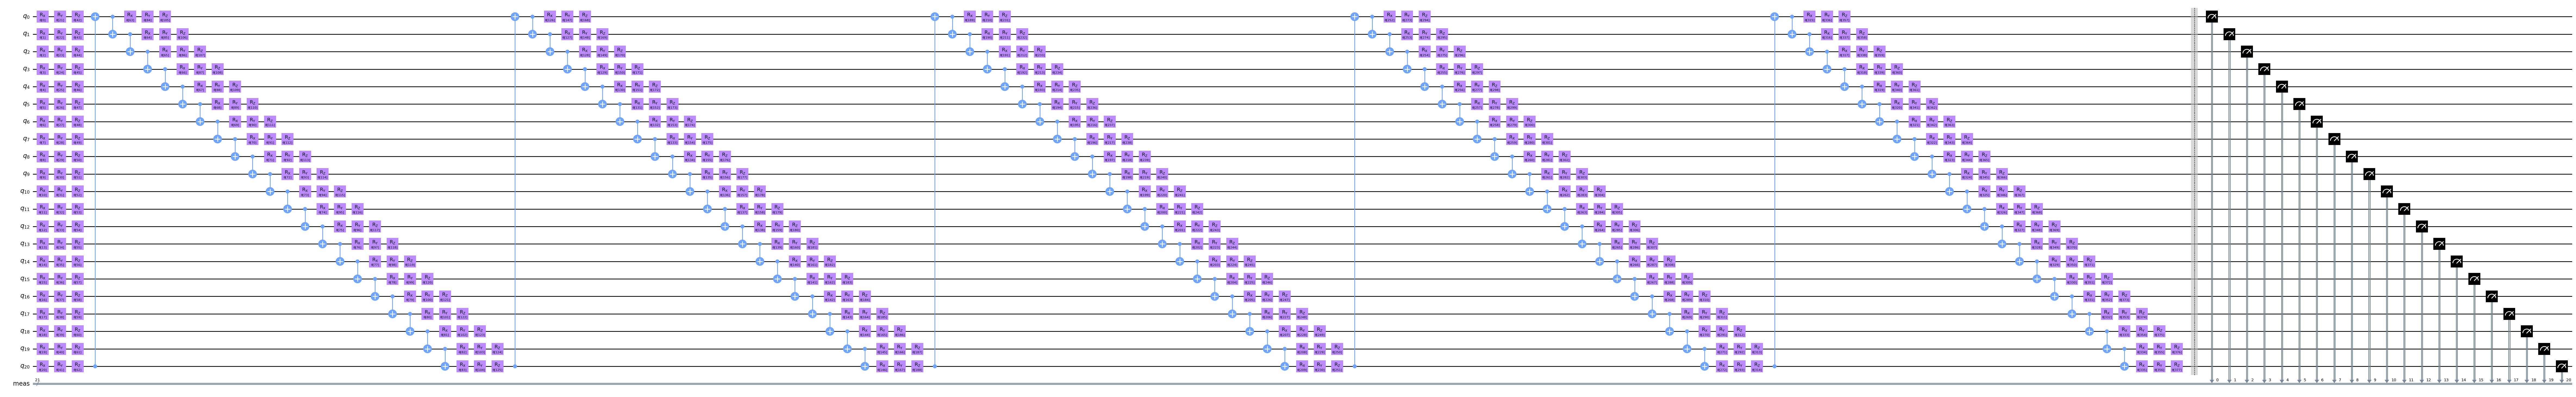

In [65]:
NUM_QUBITS_2 = int(np.log2(NUM_NODES_2))

ansatz_2 = EfficientSU2(
    num_qubits=NUM_QUBITS_2,
    reps=5,
    entanglement="circular",
    su2_gates=["rx", "ry", "rz"]
).decompose()

ansatz_2.measure_all()
ansatz_2.draw("mpl", fold=-1)

In [66]:
online_qemc_solver_2 = OnlineQEMC(NUM_NODES_2, NUM_BLUE_NODES_2)

res_2 = online_qemc_solver_2.run(
    ansatz=ansatz_2,
    opt_method=OPT_METHOD,
    opt_options=OPT_OPTIONS,
    backend=BACKEND
)

res_2

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 163969.91821289062
       x: [ 6.594e-01  2.083e+00 ...  3.584e-01  2.173e+00]
    nfev: 1000
   maxcv: 0.0

In [73]:
online_qemc_solver_2.best_prob_dist

In [67]:
sorted(online_qemc_solver_2.best_prob_dist.items(), key=lambda x: x[1], reverse=True)

AttributeError: 'NoneType' object has no attribute 'items'

In [68]:
sol_4b = prob_dist_to_partition_bitstring(
    online_qemc_solver_2.best_prob_dist,
    num_nodes_to_count=NUM_BLUE_NODES_2,
    num_nodes_total=NUM_NODES_2
)
# print(sol_4b)

cut_4b = compute_cut(graph_2, sol_4b)
print(cut_4b)

AttributeError: 'NoneType' object has no attribute 'items'

---------------------------

In [62]:
128**2

16384

## References

[[1]](https://arxiv.org/abs/2308.10383) Tene-Cohen, Y., Kelman, T., Lev, O., & Makmal, A. (2023). **A Variational Qubit-Efficient MaxCut Heuristic Algorithm**. arXiv preprint arXiv:2308.10383.

[[2]](https://link.springer.com/article/10.1007/s00453-018-0418-5) Saurabh, S., & Zehavi, M. (2018). **$(k, n-k)$-Max-Cut: An $O^*(2^p)$-Time Algorithm and a Polynomial Kernel**.

[[3]](https://xlinux.nist.gov/dads/HTML/online.html) Algorithms and Theory of Computation Handbook, CRC Press LLC, 1999, "**on-line algorithm**", in Dictionary of Algorithms and Data Structures, Paul E. Black, ed. 17 December 2004.

[[4]](https://dl.acm.org/doi/abs/10.1145/227683.227684) Goemans, Michel X., and David P. Williamson. "**Improved approximation algorithms for maximum cut and satisfiability problems using semidefinite programming.**" Journal of the ACM (JACM) 42.6 (1995): 1115-1145.

[[5]](https://dl.acm.org/doi/pdf/10.1145/62212.62233) Papadimitriou, Christos, and Mihalis Yannakakis. "**Optimization, approximation, and complexity classes.**" Proceedings of the twentieth annual ACM symposium on Theory of computing. 1988.

[[6]](http://103.62.146.201:8081/xmlui/bitstream/handle/1/3490/Introduction.to.Algorithms.3rd.Edition.Sep.2010.pdf?sequence=1&isAllowed=y) Cormen, Thomas H., Charles E. Leiserson, Ronald L. Rivest, and Clifford Stein. "**Introduction to Algorithms**". Appendix C, Pages 1186-1187, "Binomial Bounds".